In [1]:
from models_pompP import init_modelV, modelV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
def checkbound_state_vars(x_state_ens, pop, num_params=8, num_ensembles=300):
    loww = 0
    upp  = pop
    x_state_ens = np.clip(x_state_ens, 0, upp)
    return x_state_ens

In [25]:
date_init  = pd.to_datetime("2020-01-01")
date_end   = pd.to_datetime("2030-12-30")
dates      = pd.date_range(start=date_init, end=date_end, freq='1D')
num_steps = len(dates)
df_all    = []
num_iters = 10
num_var = 27
num_ensembles = 10
df_all = np.zeros((num_var, num_ensembles, num_steps, num_iters))
from tqdm import tqdm
for idx_iter in tqdm(range(num_iters)):
    
    population         = 49263774.0
    x                  = init_modelV(pop = population, num_variables=num_var, num_ensembles=num_ensembles)
    beta               = 1.075
    ihr   = 0.007366262391355804
    iV1hr = 0.02280576591751023
    iV2hr = 0.07673189990995631
    
    hfr   = 0.9510075988639394
    hV1fr = 0.3071754544330524
    hV2fr = 0.09129672949093816
    
    Vr1           = 0.0023
    Vr2           = Vr1/90
    alpha_s            = 0.84

    x_all = np.zeros((num_var, num_ensembles, num_steps))
    x_all[:,:,0]=x
    for t in range(1,num_steps):
        
        x_ens =(modelV(x=x_all[:,:,t-1], beta=beta, ihr = ihr, hfr = hfr, iV1hr=iV1hr, hV1fr=hV1fr, iV2hr=iV2hr,
                                hV2fr=hV2fr, Vr1=Vr1, Vr2=Vr2, alpha=alpha_s, N=population, num_ensembles=10))
        
        
        x_ens1 = checkbound_state_vars(x_state_ens=x_ens, pop=population, num_params= num_var, num_ensembles= num_ensembles)
        
        x_all[:,:,t]=x_ens1
    
    df_all[:,:,:,idx_iter]=x_all
# df_all = pd.concat(df_all)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.10s/it]


In [26]:
df_all.shape

(27, 10, 4017, 10)

kappa   = 1/6.4 # Incubation Period [days]
beta               = 1.075
ihr = 0.015246691373368334
hfr = 0.001/ihr
alpha            = 0.84
gamma   = 1/4   # Recovery Period   [days]
sigma   = 0.5   # Relative Unreported tranmissibility  [Adimensional]
delta   = 1/270
Ir=1
Iu=1
# N=population
# foi =  beta * (Ir + sigma*Iu) / N

((1-alpha)*kappa)+(alpha*(1-ihr)*kappa)+(ihr*kappa)+(2*gamma)+(1-hfr)+hfr

In [27]:
def create_df_response(samples, time, date_init ='2020-03-06',  quantiles = [50, 80, 95], forecast_horizon=27, dates=None, use_future=False):
    """[summary]

    Args:
        samples ([type]): [description]
        time ([type]): [description]
        date_init (str, optional): [description]. Defaults to '2020-03-06'.
        forecast_horizon (int, optional): [description]. Defaults to 27.
        use_future (bool, optional): [description]. Defaults to False.

    Returns:
        [type]: [description]
    """
    if dates is not None:
        dates_fitted = dates
    else:
        dates_fitted   = pd.date_range(start=pd.to_datetime(date_init), periods=time)
        dates_forecast = pd.date_range(start=dates_fitted[-1]+datetime.timedelta(1), periods=forecast_horizon)

    dates = list(dates_fitted)
    types = ['estimate']*len(dates_fitted)
    if use_future:
        dates += list(dates_forecast)
        types  += ['forecast']*len(dates_forecast)

    results_df = pd.DataFrame(samples.T)
    df_response = pd.DataFrame(index=dates)
    # Calculate key statistics
    df_response['mean']        = results_df.mean(axis=1).values
    df_response['median']      = results_df.median(axis=1).values
    df_response['std']         = results_df.std(axis=1).values

    for quant in quantiles:
        low_q  = ((100-quant)/2)/100
        high_q = 1-low_q

        df_response[f'low_{quant}']  = results_df.quantile(q=low_q, axis=1).values
        df_response[f'high_{quant}'] = results_df.quantile(q=high_q, axis=1).values

    df_response['type']        =  types
    df_response.index.name = 'date'
    return df_response

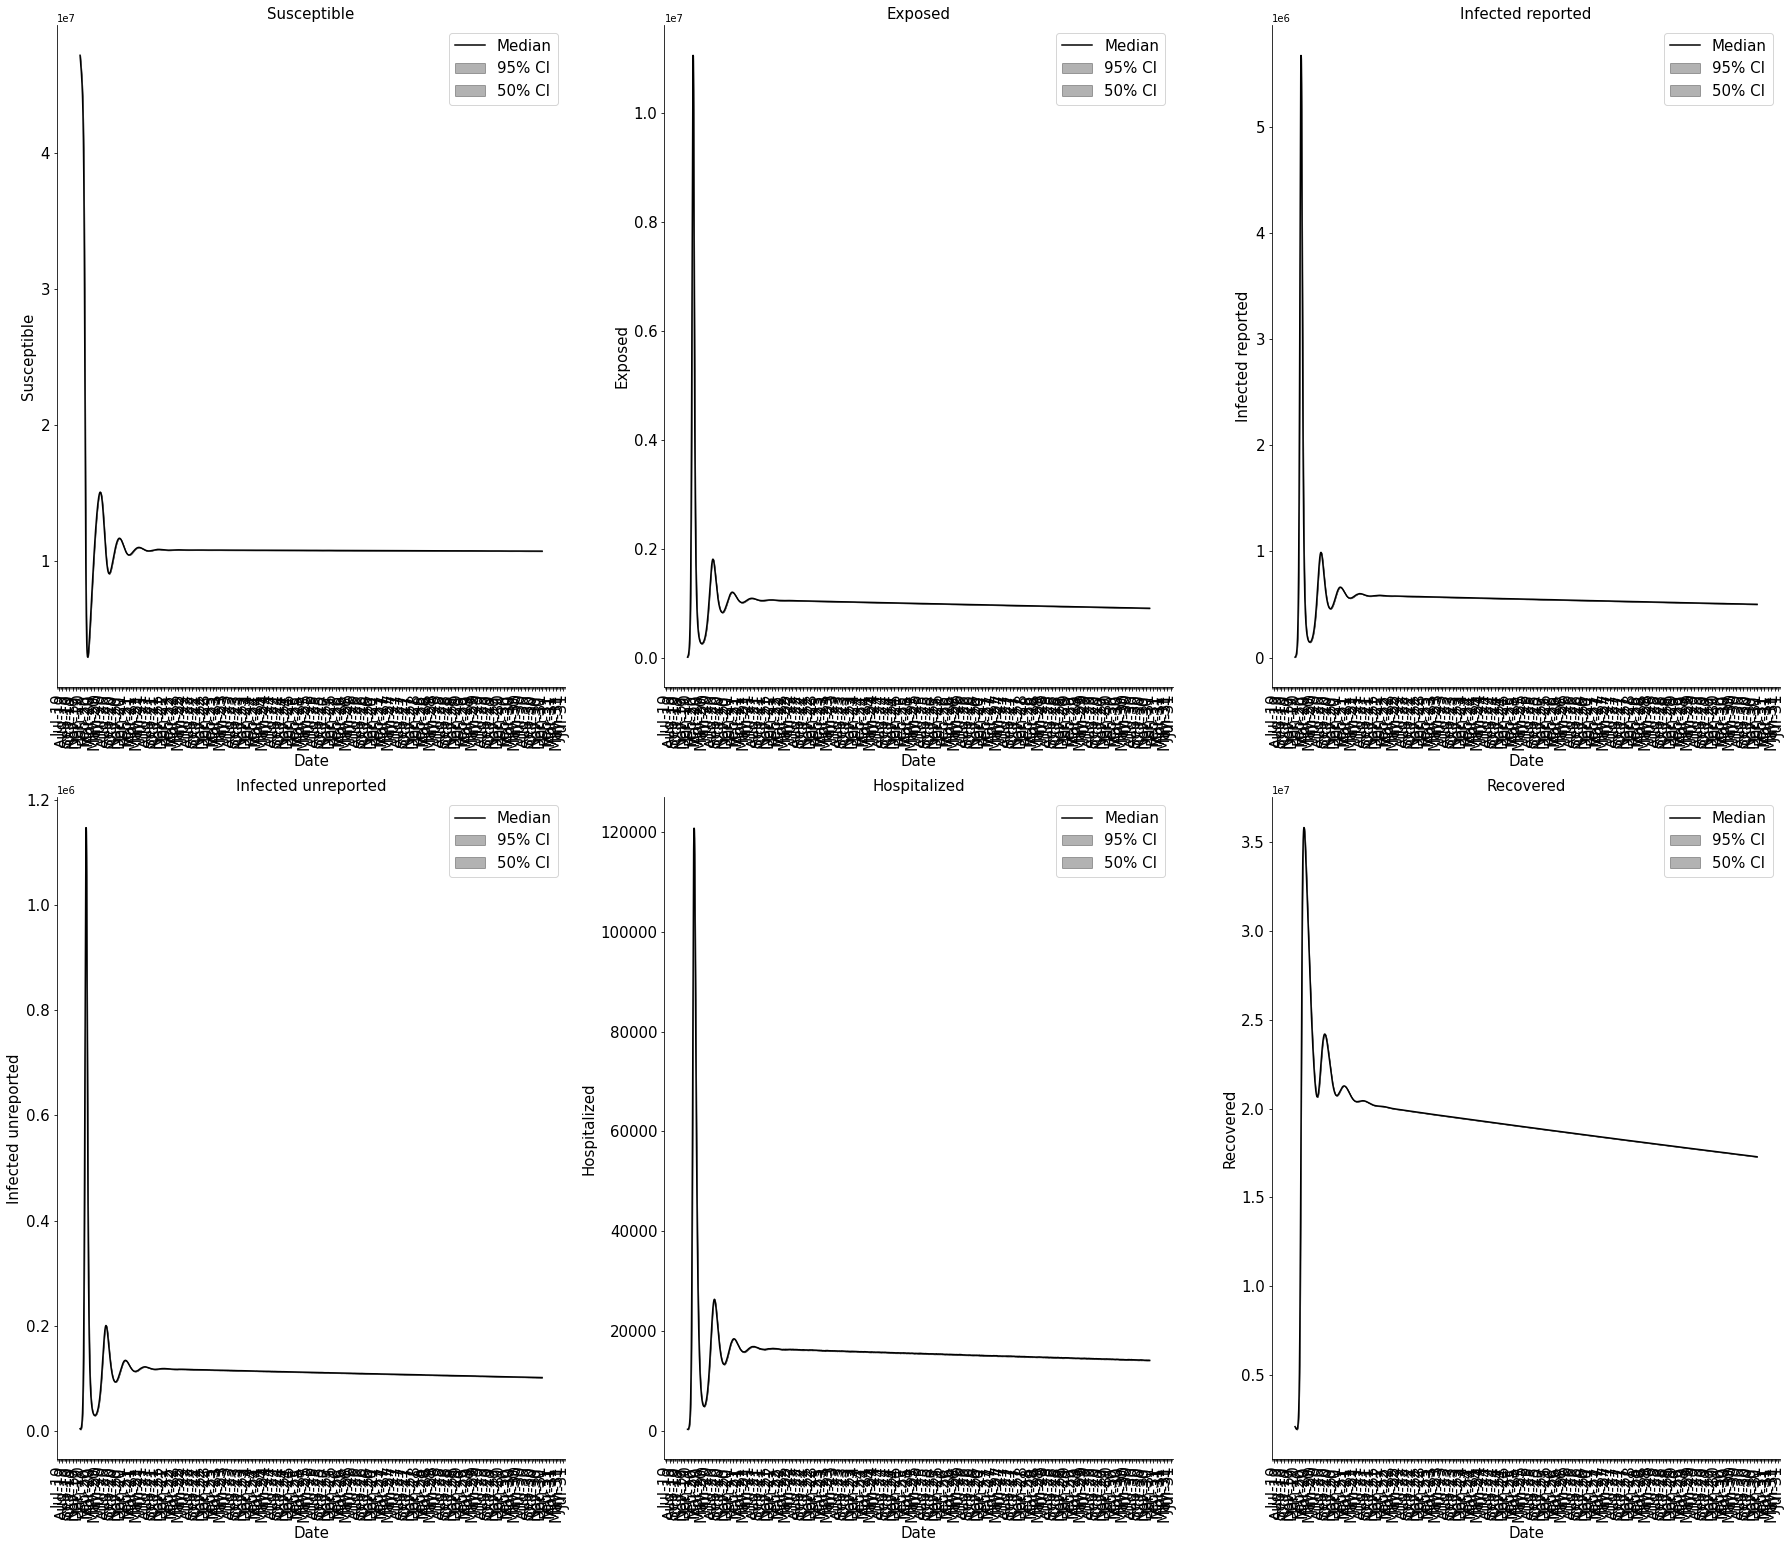

In [28]:
S_time = np.mean(df_all[0,:,:,:], -1)
E_time = np.mean(df_all[1,:,:,:], -1)
Ir_time = np.mean(df_all[2,:,:,:], -1)
Iu_time = np.mean(df_all[3,:,:,:], -1)
Ih_time = np.mean(df_all[4,:,:,:], -1)
R_time = np.mean(df_all[5,:,:,:], -1)
H_time = np.mean(df_all[6,:,:,:], -1)
C_time = np.mean(df_all[7,:,:,:], -1)
D_time = np.mean(df_all[8,:,:,:], -1)

df_S  = create_df_response(S_time, time=num_steps, dates =dates)
df_E  = create_df_response(E_time, time=num_steps, dates =dates)
df_Ir  = create_df_response(Ir_time, time=num_steps, dates =dates)
df_Iu  = create_df_response(Iu_time, time=num_steps, dates =dates)
df_Ih  = create_df_response(Ih_time, time=num_steps, dates =dates)
df_R  = create_df_response(R_time, time=num_steps, dates =dates)
df_H  = create_df_response(H_time, time=num_steps, dates =dates)
df_C  = create_df_response(C_time, time=num_steps, dates =dates)
df_D  = create_df_response(D_time, time=num_steps, dates =dates)

#---------------------------------------------------------------

fig, ax = plt.subplots(2, 3, figsize=(25, 21.6))

ax[0,0].plot(df_S.index.values, df_S["median"], color='k', label='Median')
ax[0,0].fill_between(df_S.index.values, df_S["high_95"], df_S["low_95"], color='k', alpha=0.3, label='95% CI')
ax[0,0].fill_between(df_S.index.values, df_S["high_50"], df_S["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[0,0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[0,0].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[0,0].tick_params( which='both', axis='both', labelsize=15)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['top'].set_visible(False)

ax[0,0].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[0,0].set_xlabel("Date", fontsize=15)
ax[0,0].set_ylabel("Susceptible", fontsize=15)
ax[0,0].set_title("Susceptible", fontsize=15)
ax[0,0].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[0,1].plot(df_E.index.values, df_E["median"], color='k', label='Median')
ax[0,1].fill_between(df_E.index.values, df_E["high_95"], df_E["low_95"], color='k', alpha=0.3, label='95% CI')
ax[0,1].fill_between(df_E.index.values, df_E["high_50"], df_E["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[0,1].xaxis.set_major_locator(mdates.MonthLocator())
ax[0,1].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[0,1].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[0,1].tick_params( which='both', axis='both', labelsize=15)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['top'].set_visible(False)

ax[0,1].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[0,1].set_xlabel("Date", fontsize=15)
ax[0,1].set_ylabel("Exposed", fontsize=15)
ax[0,1].set_title("Exposed", fontsize=15)
ax[0,1].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[0,2].plot(df_Ir.index.values, df_Ir["median"], color='k', label='Median')
ax[0,2].fill_between(df_Ir.index.values, df_Ir["high_95"], df_Ir["low_95"], color='k', alpha=0.3, label='95% CI')
ax[0,2].fill_between(df_Ir.index.values, df_Ir["high_50"], df_Ir["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[0,2].xaxis.set_major_locator(mdates.MonthLocator())
ax[0,2].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[0,2].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[0,2].tick_params( which='both', axis='both', labelsize=15)
ax[0,2].spines['right'].set_visible(False)
ax[0,2].spines['top'].set_visible(False)

ax[0,2].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[0,2].set_xlabel("Date", fontsize=15)
ax[0,2].set_ylabel("Infected reported", fontsize=15)
ax[0,2].set_title("Infected reported", fontsize=15)
ax[0,2].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[1,0].plot(df_Iu.index.values, df_Iu["median"], color='k', label='Median')
ax[1,0].fill_between(df_Iu.index.values, df_Iu["high_95"], df_Iu["low_95"], color='k', alpha=0.3, label='95% CI')
ax[1,0].fill_between(df_Iu.index.values, df_Iu["high_50"], df_Iu["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[1,0].xaxis.set_major_locator(mdates.MonthLocator())
ax[1,0].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[1,0].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[1,0].tick_params( which='both', axis='both', labelsize=15)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['top'].set_visible(False)

ax[1,0].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[1,0].set_xlabel("Date", fontsize=15)
ax[1,0].set_ylabel("Infected unreported", fontsize=15)
ax[1,0].set_title("Infected unreported", fontsize=15)
ax[1,0].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[1,1].plot(df_Ih.index.values, df_Ih["median"], color='k', label='Median')
ax[1,1].fill_between(df_Ih.index.values, df_Ih["high_95"], df_Ih["low_95"], color='k', alpha=0.3, label='95% CI')
ax[1,1].fill_between(df_Ih.index.values, df_Ih["high_50"], df_Ih["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[1,1].xaxis.set_major_locator(mdates.MonthLocator())
ax[1,1].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[1,1].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[1,1].tick_params( which='both', axis='both', labelsize=15)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['top'].set_visible(False)

ax[1,1].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[1,1].set_xlabel("Date", fontsize=15)
ax[1,1].set_ylabel("Hospitalized", fontsize=15)
ax[1,1].set_title("Hospitalized", fontsize=15)
ax[1,1].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[1,2].plot(df_R.index.values, df_R["median"], color='k', label='Median')
ax[1,2].fill_between(df_R.index.values, df_R["high_95"], df_R["low_95"], color='k', alpha=0.3, label='95% CI')
ax[1,2].fill_between(df_R.index.values, df_R["high_50"], df_R["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[1,2].xaxis.set_major_locator(mdates.MonthLocator())
ax[1,2].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[1,2].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[1,2].tick_params( which='both', axis='both', labelsize=15)
ax[1,2].spines['right'].set_visible(False)
ax[1,2].spines['top'].set_visible(False)

ax[1,2].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[1,2].set_xlabel("Date", fontsize=15)
ax[1,2].set_ylabel("Recovered", fontsize=15)
ax[1,2].set_title("Recovered", fontsize=15)
ax[1,2].legend(fontsize=15, loc='upper right')
plt.tight_layout()

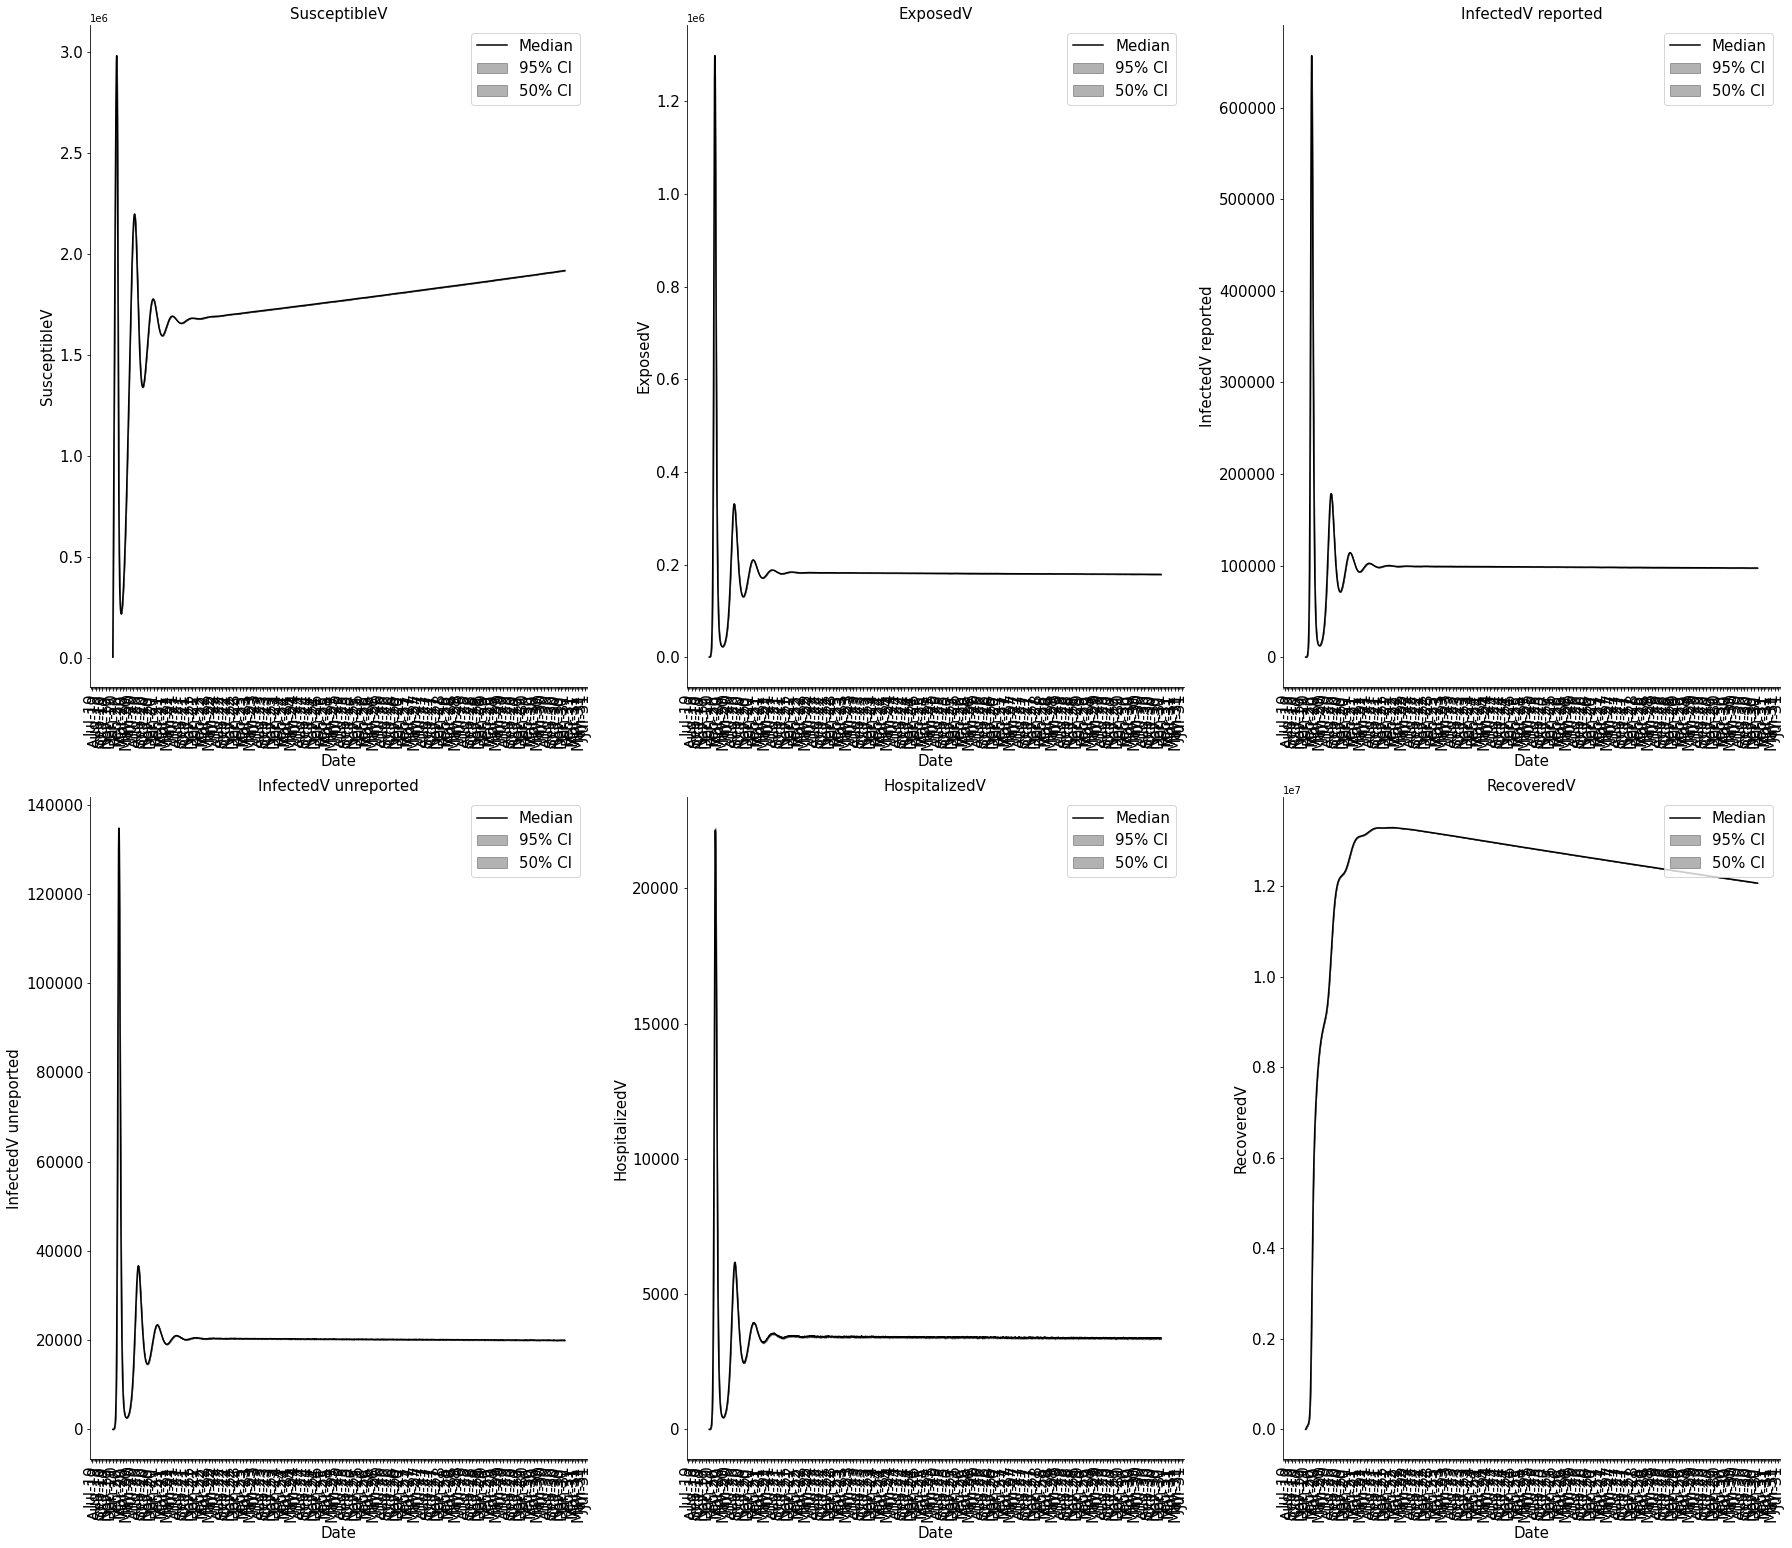

In [29]:
S_time = np.mean(df_all[9,:,:,:], -1)
E_time = np.mean(df_all[10,:,:,:], -1)
Ir_time = np.mean(df_all[11,:,:,:], -1)
Iu_time = np.mean(df_all[12,:,:,:], -1)
Ih_time = np.mean(df_all[13,:,:,:], -1)
R_time = np.mean(df_all[14,:,:,:], -1)
H_time = np.mean(df_all[15,:,:,:], -1)
C_time = np.mean(df_all[16,:,:,:], -1)
D_time = np.mean(df_all[17,:,:,:], -1)

df_S  = create_df_response(S_time, time=num_steps, dates =dates)
df_E  = create_df_response(E_time, time=num_steps, dates =dates)
df_Ir  = create_df_response(Ir_time, time=num_steps, dates =dates)
df_Iu  = create_df_response(Iu_time, time=num_steps, dates =dates)
df_Ih  = create_df_response(Ih_time, time=num_steps, dates =dates)
df_R  = create_df_response(R_time, time=num_steps, dates =dates)
df_H  = create_df_response(H_time, time=num_steps, dates =dates)
df_C  = create_df_response(C_time, time=num_steps, dates =dates)
df_D  = create_df_response(D_time, time=num_steps, dates =dates)

#---------------------------------------------------------------

fig, ax = plt.subplots(2, 3, figsize=(25, 21.6))

ax[0,0].plot(df_S.index.values, df_S["median"], color='k', label='Median')
ax[0,0].fill_between(df_S.index.values, df_S["high_95"], df_S["low_95"], color='k', alpha=0.3, label='95% CI')
ax[0,0].fill_between(df_S.index.values, df_S["high_50"], df_S["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[0,0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[0,0].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[0,0].tick_params( which='both', axis='both', labelsize=15)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['top'].set_visible(False)

ax[0,0].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[0,0].set_xlabel("Date", fontsize=15)
ax[0,0].set_ylabel("SusceptibleV", fontsize=15)
ax[0,0].set_title("SusceptibleV", fontsize=15)
ax[0,0].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[0,1].plot(df_E.index.values, df_E["median"], color='k', label='Median')
ax[0,1].fill_between(df_E.index.values, df_E["high_95"], df_E["low_95"], color='k', alpha=0.3, label='95% CI')
ax[0,1].fill_between(df_E.index.values, df_E["high_50"], df_E["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[0,1].xaxis.set_major_locator(mdates.MonthLocator())
ax[0,1].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[0,1].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[0,1].tick_params( which='both', axis='both', labelsize=15)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['top'].set_visible(False)

ax[0,1].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[0,1].set_xlabel("Date", fontsize=15)
ax[0,1].set_ylabel("ExposedV", fontsize=15)
ax[0,1].set_title("ExposedV", fontsize=15)
ax[0,1].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[0,2].plot(df_Ir.index.values, df_Ir["median"], color='k', label='Median')
ax[0,2].fill_between(df_Ir.index.values, df_Ir["high_95"], df_Ir["low_95"], color='k', alpha=0.3, label='95% CI')
ax[0,2].fill_between(df_Ir.index.values, df_Ir["high_50"], df_Ir["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[0,2].xaxis.set_major_locator(mdates.MonthLocator())
ax[0,2].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[0,2].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[0,2].tick_params( which='both', axis='both', labelsize=15)
ax[0,2].spines['right'].set_visible(False)
ax[0,2].spines['top'].set_visible(False)

ax[0,2].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[0,2].set_xlabel("Date", fontsize=15)
ax[0,2].set_ylabel("InfectedV reported", fontsize=15)
ax[0,2].set_title("InfectedV reported", fontsize=15)
ax[0,2].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[1,0].plot(df_Iu.index.values, df_Iu["median"], color='k', label='Median')
ax[1,0].fill_between(df_Iu.index.values, df_Iu["high_95"], df_Iu["low_95"], color='k', alpha=0.3, label='95% CI')
ax[1,0].fill_between(df_Iu.index.values, df_Iu["high_50"], df_Iu["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[1,0].xaxis.set_major_locator(mdates.MonthLocator())
ax[1,0].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[1,0].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[1,0].tick_params( which='both', axis='both', labelsize=15)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['top'].set_visible(False)

ax[1,0].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[1,0].set_xlabel("Date", fontsize=15)
ax[1,0].set_ylabel("InfectedV unreported", fontsize=15)
ax[1,0].set_title("InfectedV unreported", fontsize=15)
ax[1,0].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[1,1].plot(df_Ih.index.values, df_Ih["median"], color='k', label='Median')
ax[1,1].fill_between(df_Ih.index.values, df_Ih["high_95"], df_Ih["low_95"], color='k', alpha=0.3, label='95% CI')
ax[1,1].fill_between(df_Ih.index.values, df_Ih["high_50"], df_Ih["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[1,1].xaxis.set_major_locator(mdates.MonthLocator())
ax[1,1].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[1,1].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[1,1].tick_params( which='both', axis='both', labelsize=15)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['top'].set_visible(False)

ax[1,1].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[1,1].set_xlabel("Date", fontsize=15)
ax[1,1].set_ylabel("HospitalizedV", fontsize=15)
ax[1,1].set_title("HospitalizedV", fontsize=15)
ax[1,1].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[1,2].plot(df_R.index.values, df_R["median"], color='k', label='Median')
ax[1,2].fill_between(df_R.index.values, df_R["high_95"], df_R["low_95"], color='k', alpha=0.3, label='95% CI')
ax[1,2].fill_between(df_R.index.values, df_R["high_50"], df_R["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[1,2].xaxis.set_major_locator(mdates.MonthLocator())
ax[1,2].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[1,2].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[1,2].tick_params( which='both', axis='both', labelsize=15)
ax[1,2].spines['right'].set_visible(False)
ax[1,2].spines['top'].set_visible(False)

ax[1,2].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[1,2].set_xlabel("Date", fontsize=15)
ax[1,2].set_ylabel("RecoveredV", fontsize=15)
ax[1,2].set_title("RecoveredV", fontsize=15)
ax[1,2].legend(fontsize=15, loc='upper right')
plt.tight_layout()

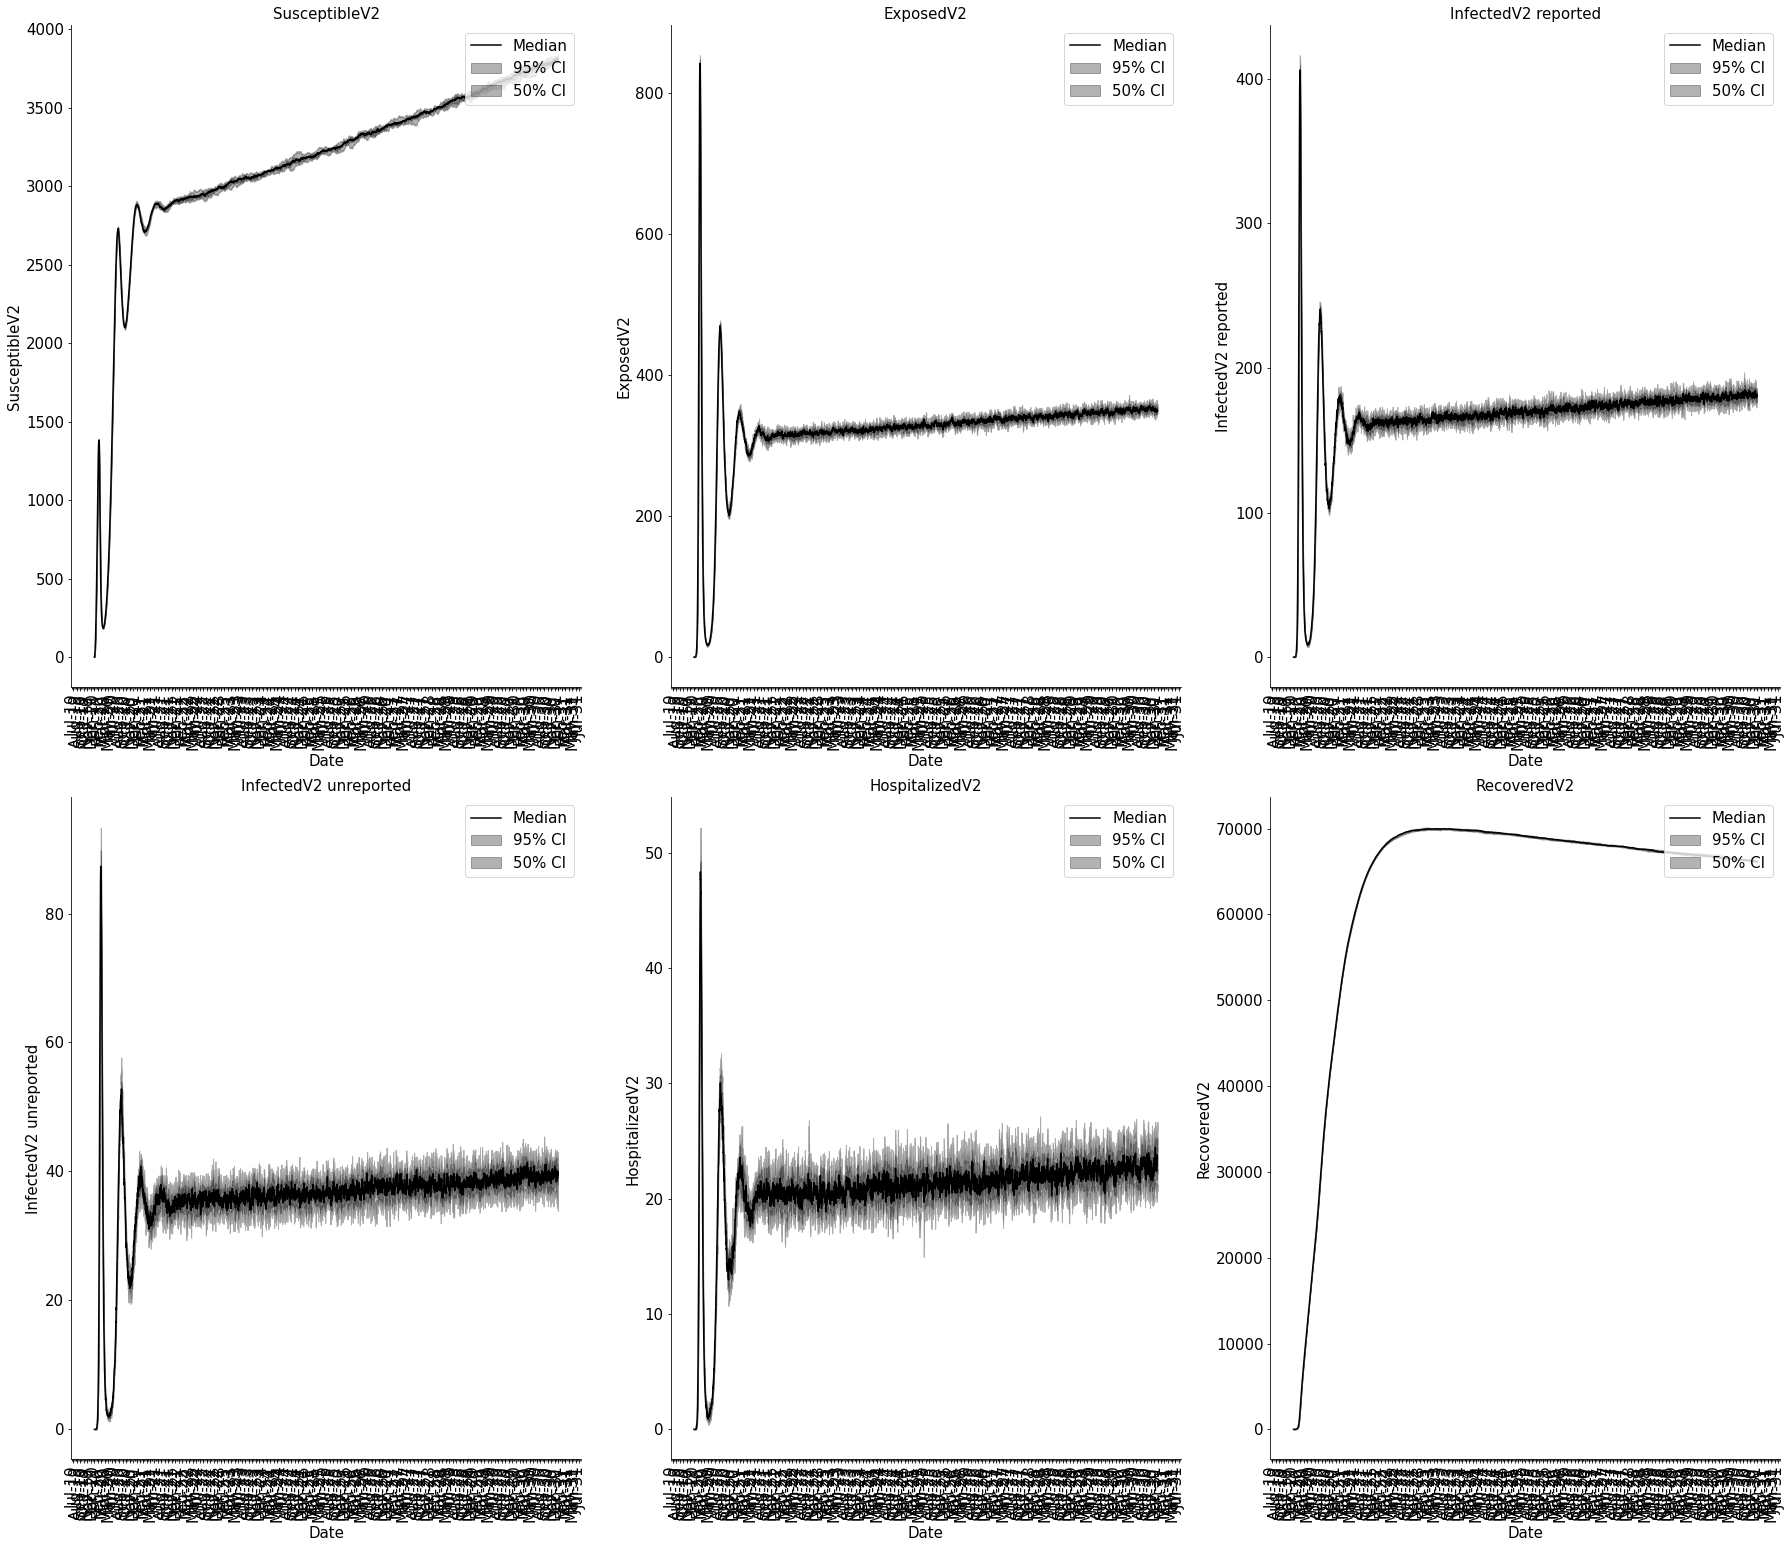

In [30]:
S_time = np.mean(df_all[18,:,:,:], -1)
E_time = np.mean(df_all[19,:,:,:], -1)
Ir_time = np.mean(df_all[20,:,:,:], -1)
Iu_time = np.mean(df_all[21,:,:,:], -1)
Ih_time = np.mean(df_all[22,:,:,:], -1)
R_time = np.mean(df_all[23,:,:,:], -1)
H_time = np.mean(df_all[24,:,:,:], -1)
C_time = np.mean(df_all[25,:,:,:], -1)
D_time = np.mean(df_all[26,:,:,:], -1)

df_S  = create_df_response(S_time, time=num_steps, dates =dates)
df_E  = create_df_response(E_time, time=num_steps, dates =dates)
df_Ir  = create_df_response(Ir_time, time=num_steps, dates =dates)
df_Iu  = create_df_response(Iu_time, time=num_steps, dates =dates)
df_Ih  = create_df_response(Ih_time, time=num_steps, dates =dates)
df_R  = create_df_response(R_time, time=num_steps, dates =dates)
df_H  = create_df_response(H_time, time=num_steps, dates =dates)
df_C  = create_df_response(C_time, time=num_steps, dates =dates)
df_D  = create_df_response(D_time, time=num_steps, dates =dates)

#---------------------------------------------------------------

fig, ax = plt.subplots(2, 3, figsize=(25, 21.6))

ax[0,0].plot(df_S.index.values, df_S["median"], color='k', label='Median')
ax[0,0].fill_between(df_S.index.values, df_S["high_95"], df_S["low_95"], color='k', alpha=0.3, label='95% CI')
ax[0,0].fill_between(df_S.index.values, df_S["high_50"], df_S["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[0,0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[0,0].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[0,0].tick_params( which='both', axis='both', labelsize=15)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['top'].set_visible(False)

ax[0,0].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[0,0].set_xlabel("Date", fontsize=15)
ax[0,0].set_ylabel("SusceptibleV2", fontsize=15)
ax[0,0].set_title("SusceptibleV2", fontsize=15)
ax[0,0].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[0,1].plot(df_E.index.values, df_E["median"], color='k', label='Median')
ax[0,1].fill_between(df_E.index.values, df_E["high_95"], df_E["low_95"], color='k', alpha=0.3, label='95% CI')
ax[0,1].fill_between(df_E.index.values, df_E["high_50"], df_E["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[0,1].xaxis.set_major_locator(mdates.MonthLocator())
ax[0,1].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[0,1].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[0,1].tick_params( which='both', axis='both', labelsize=15)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['top'].set_visible(False)

ax[0,1].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[0,1].set_xlabel("Date", fontsize=15)
ax[0,1].set_ylabel("ExposedV2", fontsize=15)
ax[0,1].set_title("ExposedV2", fontsize=15)
ax[0,1].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[0,2].plot(df_Ir.index.values, df_Ir["median"], color='k', label='Median')
ax[0,2].fill_between(df_Ir.index.values, df_Ir["high_95"], df_Ir["low_95"], color='k', alpha=0.3, label='95% CI')
ax[0,2].fill_between(df_Ir.index.values, df_Ir["high_50"], df_Ir["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[0,2].xaxis.set_major_locator(mdates.MonthLocator())
ax[0,2].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[0,2].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[0,2].tick_params( which='both', axis='both', labelsize=15)
ax[0,2].spines['right'].set_visible(False)
ax[0,2].spines['top'].set_visible(False)

ax[0,2].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[0,2].set_xlabel("Date", fontsize=15)
ax[0,2].set_ylabel("InfectedV2 reported", fontsize=15)
ax[0,2].set_title("InfectedV2 reported", fontsize=15)
ax[0,2].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[1,0].plot(df_Iu.index.values, df_Iu["median"], color='k', label='Median')
ax[1,0].fill_between(df_Iu.index.values, df_Iu["high_95"], df_Iu["low_95"], color='k', alpha=0.3, label='95% CI')
ax[1,0].fill_between(df_Iu.index.values, df_Iu["high_50"], df_Iu["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[1,0].xaxis.set_major_locator(mdates.MonthLocator())
ax[1,0].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[1,0].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[1,0].tick_params( which='both', axis='both', labelsize=15)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['top'].set_visible(False)

ax[1,0].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[1,0].set_xlabel("Date", fontsize=15)
ax[1,0].set_ylabel("InfectedV2 unreported", fontsize=15)
ax[1,0].set_title("InfectedV2 unreported", fontsize=15)
ax[1,0].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[1,1].plot(df_Ih.index.values, df_Ih["median"], color='k', label='Median')
ax[1,1].fill_between(df_Ih.index.values, df_Ih["high_95"], df_Ih["low_95"], color='k', alpha=0.3, label='95% CI')
ax[1,1].fill_between(df_Ih.index.values, df_Ih["high_50"], df_Ih["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[1,1].xaxis.set_major_locator(mdates.MonthLocator())
ax[1,1].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[1,1].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[1,1].tick_params( which='both', axis='both', labelsize=15)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['top'].set_visible(False)

ax[1,1].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[1,1].set_xlabel("Date", fontsize=15)
ax[1,1].set_ylabel("HospitalizedV2", fontsize=15)
ax[1,1].set_title("HospitalizedV2", fontsize=15)
ax[1,1].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[1,2].plot(df_R.index.values, df_R["median"], color='k', label='Median')
ax[1,2].fill_between(df_R.index.values, df_R["high_95"], df_R["low_95"], color='k', alpha=0.3, label='95% CI')
ax[1,2].fill_between(df_R.index.values, df_R["high_50"], df_R["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[1,2].xaxis.set_major_locator(mdates.MonthLocator())
ax[1,2].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[1,2].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[1,2].tick_params( which='both', axis='both', labelsize=15)
ax[1,2].spines['right'].set_visible(False)
ax[1,2].spines['top'].set_visible(False)

ax[1,2].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[1,2].set_xlabel("Date", fontsize=15)
ax[1,2].set_ylabel("RecoveredV2", fontsize=15)
ax[1,2].set_title("RecoveredV2", fontsize=15)
ax[1,2].legend(fontsize=15, loc='upper right')
plt.tight_layout()

NameError: name 'df_C' is not defined

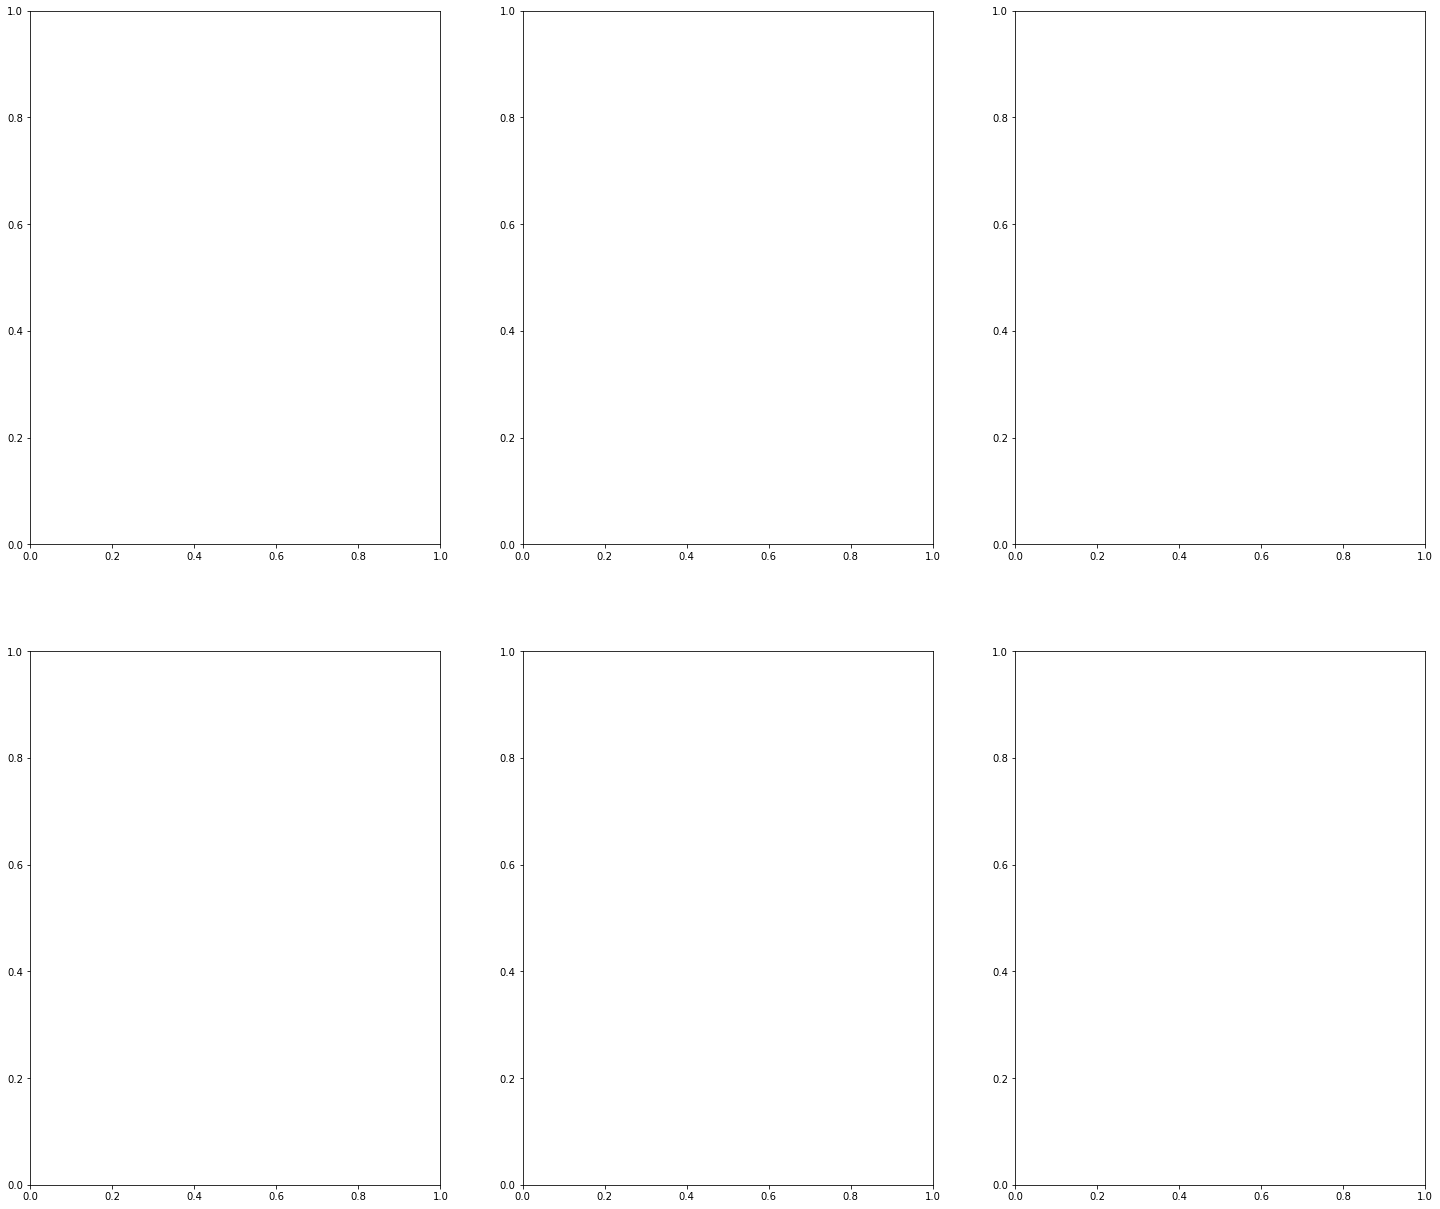

In [8]:
fig, ax = plt.subplots(2, 3, figsize=(25, 21.6))
ax[0,0].plot(df_C.index.values, df_C["median"], color='k', label='Median')
ax[0,0].fill_between(df_C.index.values, df_C["high_95"], df_C["low_95"], color='k', alpha=0.3, label='95% CI')
ax[0,0].fill_between(df_C.index.values, df_C["high_50"], df_C["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_Cesponse, x='date', y='valuye')

ax[0,0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[0,0].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[0,0].tick_params( which='both', axis='both', labelsize=15)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['top'].set_visible(False)

ax[0,0].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[0,0].set_xlabel("Date", fontsize=15)
ax[0,0].set_ylabel("Recovered", fontsize=15)
ax[0,0].set_title("Recovered", fontsize=15)
ax[0,0].legend(fontsize=15, loc='upper right')
plt.tight_layout()
ax[0,1].plot(df_H.index.values, df_H["median"], color='k', label='Median')
ax[0,1].fill_between(df_H.index.values, df_H["high_95"], df_H["low_95"], color='k', alpha=0.3, label='95% CI')
ax[0,1].fill_between(df_H.index.values, df_H["high_50"], df_H["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_Hesponse, x='date', y='valuye')

ax[0,1].xaxis.set_major_locator(mdates.MonthLocator())
ax[0,1].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[0,1].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[0,1].tick_params( which='both', axis='both', labelsize=15)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['top'].set_visible(False)

ax[0,1].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[0,1].set_xlabel("Date", fontsize=15)
ax[0,1].set_ylabel("Recovered", fontsize=15)
ax[0,1].set_title("Recovered", fontsize=15)
ax[0,1].legend(fontsize=15, loc='upper right')
plt.tight_layout()
ax[0,2].plot(df_D.index.values, df_D["median"], color='k', label='Median')
ax[0,2].fill_between(df_D.index.values, df_D["high_95"], df_D["low_95"], color='k', alpha=0.3, label='95% CI')
ax[0,2].fill_between(df_D.index.values, df_D["high_50"], df_D["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_Desponse, x='date', y='valuye')

ax[0,2].xaxis.set_major_locator(mdates.MonthLocator())
ax[0,2].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[0,2].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[0,2].tick_params( which='both', axis='both', labelsize=15)
ax[0,2].spines['right'].set_visible(False)
ax[0,2].spines['top'].set_visible(False)

ax[0,2].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[0,2].set_xlabel("Date", fontsize=15)
ax[0,2].set_ylabel("Recovered", fontsize=15)
ax[0,2].set_title("Recovered", fontsize=15)
ax[0,2].legend(fontsize=15, loc='upper right')
plt.tight_layout()


In [8]:
1.6e6*ihr

24394.706197389336

In [11]:
df_S.iloc[-1]

mean        9185109.232
median       9195838.11
std        27637.429451
low_50       9168888.85
high_50     9204819.025
low_80      9155972.732
high_80     9206388.108
low_95      9132671.948
high_95     9209146.347
type           estimate
Name: 2020-12-30 00:00:00, dtype: object

In [12]:
df_R.iloc[-1]['median']/population

0.7873929770382594

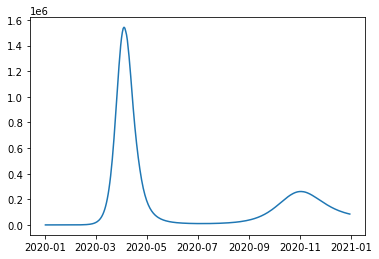

In [19]:
plt.plot(df_C['median'])

# Vacunas

In [10]:
from models_pomp import init_modelV, modelV
num_steps = 365*5
date_init  = pd.to_datetime("2020-01-01")
date_end   = pd.to_datetime("2024-12-30")
dates      = pd.date_range(start=date_init, end=date_end, freq='1D')
df_all    = []
num_iters = 20
num_var = 19
num_ensembles = 10
df_all = np.zeros((num_var, num_ensembles, num_steps, num_iters))
from tqdm import tqdm
for idx_iter in tqdm(range(num_iters)):
    
    population         = 49263774.0
    x                  = init_modelV(pop = population, num_variables=num_var, num_ensembles=num_ensembles)
    beta               = 1.075
    ihr = 0.015246691373368334
    hfr = 0.001/ihr
    rV            = 0.007#5.168e-6
    iVhr = 0.10832738810817368
    hVfr = (1-0.932)*hfr
    alpha_s            = 0.84

    x_all = np.zeros((num_var, num_ensembles, num_steps))
    x_all[:,:,0]=x
    for t in range(1,num_steps):
        x_ens = []
        for idx_ens in range(num_ensembles):

            x_ens.append(modelV(x=x[:,idx_ens], beta=beta, ihr=ihr, hfr = hfr, iVhr= iVhr, hVfr=hVfr, rV= rV, alpha=alpha_s, N=population))

        x_ens = np.array(x_ens).T
        x_ens = checkbound_state_vars(x_state_ens=x_ens, pop=population, num_params= num_var, num_ensembles= num_ensembles)
        x = x_ens
        
        x_all[:,:,t]=x_ens

    df_all[:,:,:,idx_iter] = x_all
# df_all = pd.concat(df_all)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:44<00:00,  2.24s/it]


In [12]:
date_init  = pd.to_datetime("2020-01-01")
date_end   = pd.to_datetime("2024-12-29")
dates      = pd.date_range(start=date_init, end=date_end, freq='1D')
len(dates)

1825

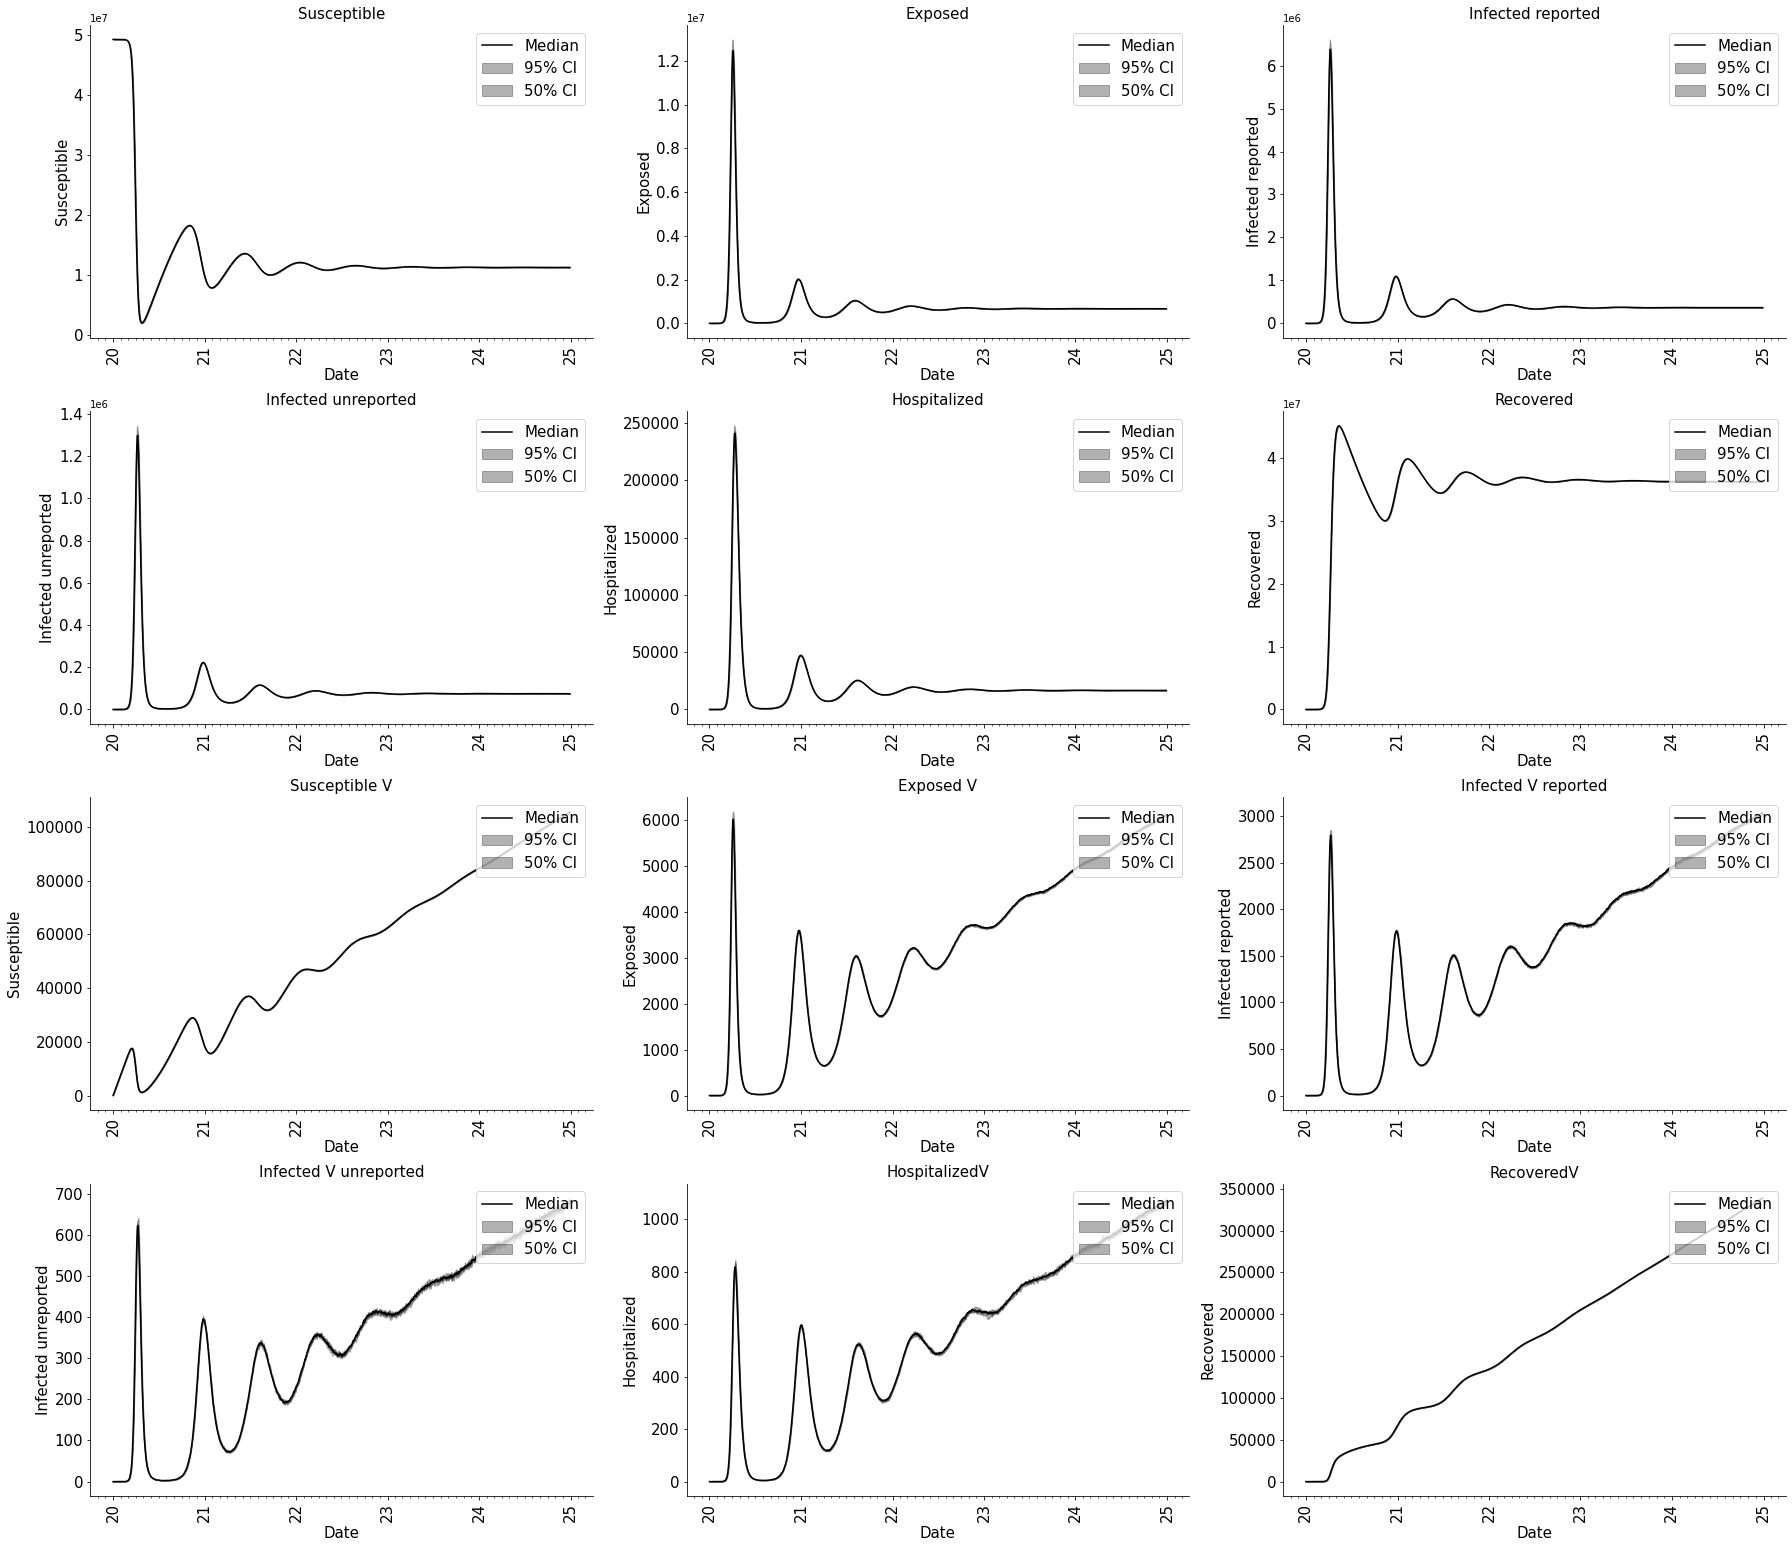

In [5]:
S_time = np.mean(df_all[0,:,:,:], -1)
E_time = np.mean(df_all[1,:,:,:], -1)
Ir_time = np.mean(df_all[2,:,:,:], -1)
Iu_time = np.mean(df_all[3,:,:,:], -1)
Ih_time = np.mean(df_all[4,:,:,:], -1)
R_time = np.mean(df_all[5,:,:,:], -1)
H_time = np.mean(df_all[6,:,:,:], -1)
C_time = np.mean(df_all[7,:,:,:], -1)
D_time = np.mean(df_all[8,:,:,:], -1)
SV_time = np.mean(df_all[9,:,:,:], -1)
EV_time = np.mean(df_all[10,:,:,:], -1)
IVr_time = np.mean(df_all[11,:,:,:], -1)
IVu_time = np.mean(df_all[12,:,:,:], -1)
IVh_time = np.mean(df_all[13,:,:,:], -1)
RV_time = np.mean(df_all[14,:,:,:], -1)
HV_time = np.mean(df_all[15,:,:,:], -1)
CV_time = np.mean(df_all[16,:,:,:], -1)
DV_time = np.mean(df_all[17,:,:,:], -1)

df_S  = create_df_response(S_time, time=num_steps, dates =dates)
df_E  = create_df_response(E_time, time=num_steps, dates =dates)
df_Ir  = create_df_response(Ir_time, time=num_steps, dates =dates)
df_Iu  = create_df_response(Iu_time, time=num_steps, dates =dates)
df_Ih  = create_df_response(Ih_time, time=num_steps, dates =dates)
df_R  = create_df_response(R_time, time=num_steps, dates =dates)
df_H  = create_df_response(H_time, time=num_steps, dates =dates)
df_C  = create_df_response(C_time, time=num_steps, dates =dates)
df_D  = create_df_response(D_time, time=num_steps, dates =dates)

df_SV  = create_df_response(SV_time, time=num_steps, dates =dates)
df_EV  = create_df_response(EV_time, time=num_steps, dates =dates)
df_IVr  = create_df_response(IVr_time, time=num_steps, dates =dates)
df_IVu  = create_df_response(IVu_time, time=num_steps, dates =dates)
df_IVh  = create_df_response(IVh_time, time=num_steps, dates =dates)
df_RV  = create_df_response(RV_time, time=num_steps, dates =dates)
df_HV  = create_df_response(HV_time, time=num_steps, dates =dates)
df_CV  = create_df_response(CV_time, time=num_steps, dates =dates)
df_DV  = create_df_response(DV_time, time=num_steps, dates =dates)

#---------------------------------------------------------------

fig, ax = plt.subplots(4, 3, figsize=(25, 21.6))

ax[0,0].plot(df_S.index.values, df_S["median"], color='k', label='Median')
ax[0,0].fill_between(df_S.index.values, df_S["high_95"], df_S["low_95"], color='k', alpha=0.3, label='95% CI')
ax[0,0].fill_between(df_S.index.values, df_S["high_50"], df_S["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[0,0].xaxis.set_major_locator(mdates.YearLocator())
ax[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%y'))
ax[0,0].xaxis.set_minor_locator(mdates.MonthLocator())
ax[0,0].tick_params( which='both', axis='both', labelsize=15)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['top'].set_visible(False)

ax[0,0].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[0,0].set_xlabel("Date", fontsize=15)
ax[0,0].set_ylabel("Susceptible", fontsize=15)
ax[0,0].set_title("Susceptible", fontsize=15)
ax[0,0].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[0,1].plot(df_E.index.values, df_E["median"], color='k', label='Median')
ax[0,1].fill_between(df_E.index.values, df_E["high_95"], df_E["low_95"], color='k', alpha=0.3, label='95% CI')
ax[0,1].fill_between(df_E.index.values, df_E["high_50"], df_E["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[0,1].xaxis.set_major_locator(mdates.YearLocator())
ax[0,1].xaxis.set_major_formatter(mdates.DateFormatter('%y'))
ax[0,1].xaxis.set_minor_locator(mdates.MonthLocator())
ax[0,1].tick_params( which='both', axis='both', labelsize=15)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['top'].set_visible(False)

ax[0,1].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[0,1].set_xlabel("Date", fontsize=15)
ax[0,1].set_ylabel("Exposed", fontsize=15)
ax[0,1].set_title("Exposed", fontsize=15)
ax[0,1].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[0,2].plot(df_Ir.index.values, df_Ir["median"], color='k', label='Median')
ax[0,2].fill_between(df_Ir.index.values, df_Ir["high_95"], df_Ir["low_95"], color='k', alpha=0.3, label='95% CI')
ax[0,2].fill_between(df_Ir.index.values, df_Ir["high_50"], df_Ir["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[0,2].xaxis.set_major_locator(mdates.YearLocator())
ax[0,2].xaxis.set_major_formatter(mdates.DateFormatter('%y'))
ax[0,2].xaxis.set_minor_locator(mdates.MonthLocator())
ax[0,2].tick_params( which='both', axis='both', labelsize=15)
ax[0,2].spines['right'].set_visible(False)
ax[0,2].spines['top'].set_visible(False)

ax[0,2].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[0,2].set_xlabel("Date", fontsize=15)
ax[0,2].set_ylabel("Infected reported", fontsize=15)
ax[0,2].set_title("Infected reported", fontsize=15)
ax[0,2].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[1,0].plot(df_Iu.index.values, df_Iu["median"], color='k', label='Median')
ax[1,0].fill_between(df_Iu.index.values, df_Iu["high_95"], df_Iu["low_95"], color='k', alpha=0.3, label='95% CI')
ax[1,0].fill_between(df_Iu.index.values, df_Iu["high_50"], df_Iu["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[1,0].xaxis.set_major_locator(mdates.YearLocator())
ax[1,0].xaxis.set_major_formatter(mdates.DateFormatter('%y'))
ax[1,0].xaxis.set_minor_locator(mdates.MonthLocator())
ax[1,0].tick_params( which='both', axis='both', labelsize=15)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['top'].set_visible(False)

ax[1,0].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[1,0].set_xlabel("Date", fontsize=15)
ax[1,0].set_ylabel("Infected unreported", fontsize=15)
ax[1,0].set_title("Infected unreported", fontsize=15)
ax[1,0].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[1,1].plot(df_Ih.index.values, df_Ih["median"], color='k', label='Median')
ax[1,1].fill_between(df_Ih.index.values, df_Ih["high_95"], df_Ih["low_95"], color='k', alpha=0.3, label='95% CI')
ax[1,1].fill_between(df_Ih.index.values, df_Ih["high_50"], df_Ih["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[1,1].xaxis.set_major_locator(mdates.YearLocator())
ax[1,1].xaxis.set_major_formatter(mdates.DateFormatter('%y'))
ax[1,1].xaxis.set_minor_locator(mdates.MonthLocator())
ax[1,1].tick_params( which='both', axis='both', labelsize=15)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['top'].set_visible(False)

ax[1,1].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[1,1].set_xlabel("Date", fontsize=15)
ax[1,1].set_ylabel("Hospitalized", fontsize=15)
ax[1,1].set_title("Hospitalized", fontsize=15)
ax[1,1].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[1,2].plot(df_R.index.values, df_R["median"], color='k', label='Median')
ax[1,2].fill_between(df_R.index.values, df_R["high_95"], df_R["low_95"], color='k', alpha=0.3, label='95% CI')
ax[1,2].fill_between(df_R.index.values, df_R["high_50"], df_R["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[1,2].xaxis.set_major_locator(mdates.YearLocator())
ax[1,2].xaxis.set_major_formatter(mdates.DateFormatter('%y'))
ax[1,2].xaxis.set_minor_locator(mdates.MonthLocator())
ax[1,2].tick_params( which='both', axis='both', labelsize=15)
ax[1,2].spines['right'].set_visible(False)
ax[1,2].spines['top'].set_visible(False)

ax[1,2].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[1,2].set_xlabel("Date", fontsize=15)
ax[1,2].set_ylabel("Recovered", fontsize=15)
ax[1,2].set_title("Recovered", fontsize=15)
ax[1,2].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------



ax[2,0].plot(df_SV.index.values, df_SV["median"], color='k', label='Median')
ax[2,0].fill_between(df_SV.index.values, df_SV["high_95"], df_SV["low_95"], color='k', alpha=0.3, label='95% CI')
ax[2,0].fill_between(df_SV.index.values, df_SV["high_50"], df_SV["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[2,0].xaxis.set_major_locator(mdates.YearLocator())
ax[2,0].xaxis.set_major_formatter(mdates.DateFormatter('%y'))
ax[2,0].xaxis.set_minor_locator(mdates.MonthLocator())
ax[2,0].tick_params( which='both', axis='both', labelsize=15)
ax[2,0].spines['right'].set_visible(False)
ax[2,0].spines['top'].set_visible(False)

ax[2,0].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[2,0].set_xlabel("Date", fontsize=15)
ax[2,0].set_ylabel("Susceptible", fontsize=15)
ax[2,0].set_title("Susceptible V", fontsize=15)
ax[2,0].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[2,1].plot(df_EV.index.values, df_EV["median"], color='k', label='Median')
ax[2,1].fill_between(df_EV.index.values, df_EV["high_95"], df_EV["low_95"], color='k', alpha=0.3, label='95% CI')
ax[2,1].fill_between(df_EV.index.values, df_EV["high_50"], df_EV["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[2,1].xaxis.set_major_locator(mdates.YearLocator())
ax[2,1].xaxis.set_major_formatter(mdates.DateFormatter('%y'))
ax[2,1].xaxis.set_minor_locator(mdates.MonthLocator())
ax[2,1].tick_params( which='both', axis='both', labelsize=15)
ax[2,1].spines['right'].set_visible(False)
ax[2,1].spines['top'].set_visible(False)

ax[2,1].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[2,1].set_xlabel("Date", fontsize=15)
ax[2,1].set_ylabel("Exposed", fontsize=15)
ax[2,1].set_title("Exposed V", fontsize=15)
ax[2,1].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[2,2].plot(df_IVr.index.values, df_IVr["median"], color='k', label='Median')
ax[2,2].fill_between(df_IVr.index.values, df_IVr["high_95"], df_IVr["low_95"], color='k', alpha=0.3, label='95% CI')
ax[2,2].fill_between(df_IVr.index.values, df_IVr["high_50"], df_IVr["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[2,2].xaxis.set_major_locator(mdates.YearLocator())
ax[2,2].xaxis.set_major_formatter(mdates.DateFormatter('%y'))
ax[2,2].xaxis.set_minor_locator(mdates.MonthLocator())
ax[2,2].tick_params( which='both', axis='both', labelsize=15)
ax[2,2].spines['right'].set_visible(False)
ax[2,2].spines['top'].set_visible(False)

ax[2,2].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[2,2].set_xlabel("Date", fontsize=15)
ax[2,2].set_ylabel("Infected reported", fontsize=15)
ax[2,2].set_title("Infected V reported", fontsize=15)
ax[2,2].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[3,0].plot(df_IVu.index.values, df_IVu["median"], color='k', label='Median')
ax[3,0].fill_between(df_IVu.index.values, df_IVu["high_95"], df_IVu["low_95"], color='k', alpha=0.3, label='95% CI')
ax[3,0].fill_between(df_IVu.index.values, df_IVu["high_50"], df_IVu["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[3,0].xaxis.set_major_locator(mdates.YearLocator())
ax[3,0].xaxis.set_major_formatter(mdates.DateFormatter('%y'))
ax[3,0].xaxis.set_minor_locator(mdates.MonthLocator())
ax[3,0].tick_params( which='both', axis='both', labelsize=15)
ax[3,0].spines['right'].set_visible(False)
ax[3,0].spines['top'].set_visible(False)

ax[3,0].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[3,0].set_xlabel("Date", fontsize=15)
ax[3,0].set_ylabel("Infected unreported", fontsize=15)
ax[3,0].set_title("Infected V unreported", fontsize=15)
ax[3,0].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[3,1].plot(df_IVh.index.values, df_IVh["median"], color='k', label='Median')
ax[3,1].fill_between(df_IVh.index.values, df_IVh["high_95"], df_IVh["low_95"], color='k', alpha=0.3, label='95% CI')
ax[3,1].fill_between(df_IVh.index.values, df_IVh["high_50"], df_IVh["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[3,1].xaxis.set_major_locator(mdates.YearLocator())
ax[3,1].xaxis.set_major_formatter(mdates.DateFormatter('%y'))
ax[3,1].xaxis.set_minor_locator(mdates.MonthLocator())
ax[3,1].tick_params( which='both', axis='both', labelsize=15)
ax[3,1].spines['right'].set_visible(False)
ax[3,1].spines['top'].set_visible(False)

ax[3,1].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[3,1].set_xlabel("Date", fontsize=15)
ax[3,1].set_ylabel("Hospitalized", fontsize=15)
ax[3,1].set_title("HospitalizedV", fontsize=15)
ax[3,1].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[3,2].plot(df_RV.index.values, df_RV["median"], color='k', label='Median')
ax[3,2].fill_between(df_RV.index.values, df_RV["high_95"], df_RV["low_95"], color='k', alpha=0.3, label='95% CI')
ax[3,2].fill_between(df_RV.index.values, df_RV["high_50"], df_RV["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[3,2].xaxis.set_major_locator(mdates.YearLocator())
ax[3,2].xaxis.set_major_formatter(mdates.DateFormatter('%y'))
ax[3,2].xaxis.set_minor_locator(mdates.MonthLocator())
ax[3,2].tick_params( which='both', axis='both', labelsize=15)
ax[3,2].spines['right'].set_visible(False)
ax[3,2].spines['top'].set_visible(False)

ax[3,2].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[3,2].set_xlabel("Date", fontsize=15)
ax[3,2].set_ylabel("Recovered", fontsize=15)
ax[3,2].set_title("RecoveredV", fontsize=15)
ax[3,2].legend(fontsize=15, loc='upper right')
plt.tight_layout()

In [6]:
df_Vac=df_SV+df_EV+df_IVr+df_IVu+df_IVh+df_RV+df_HV+df_CV+df_DV

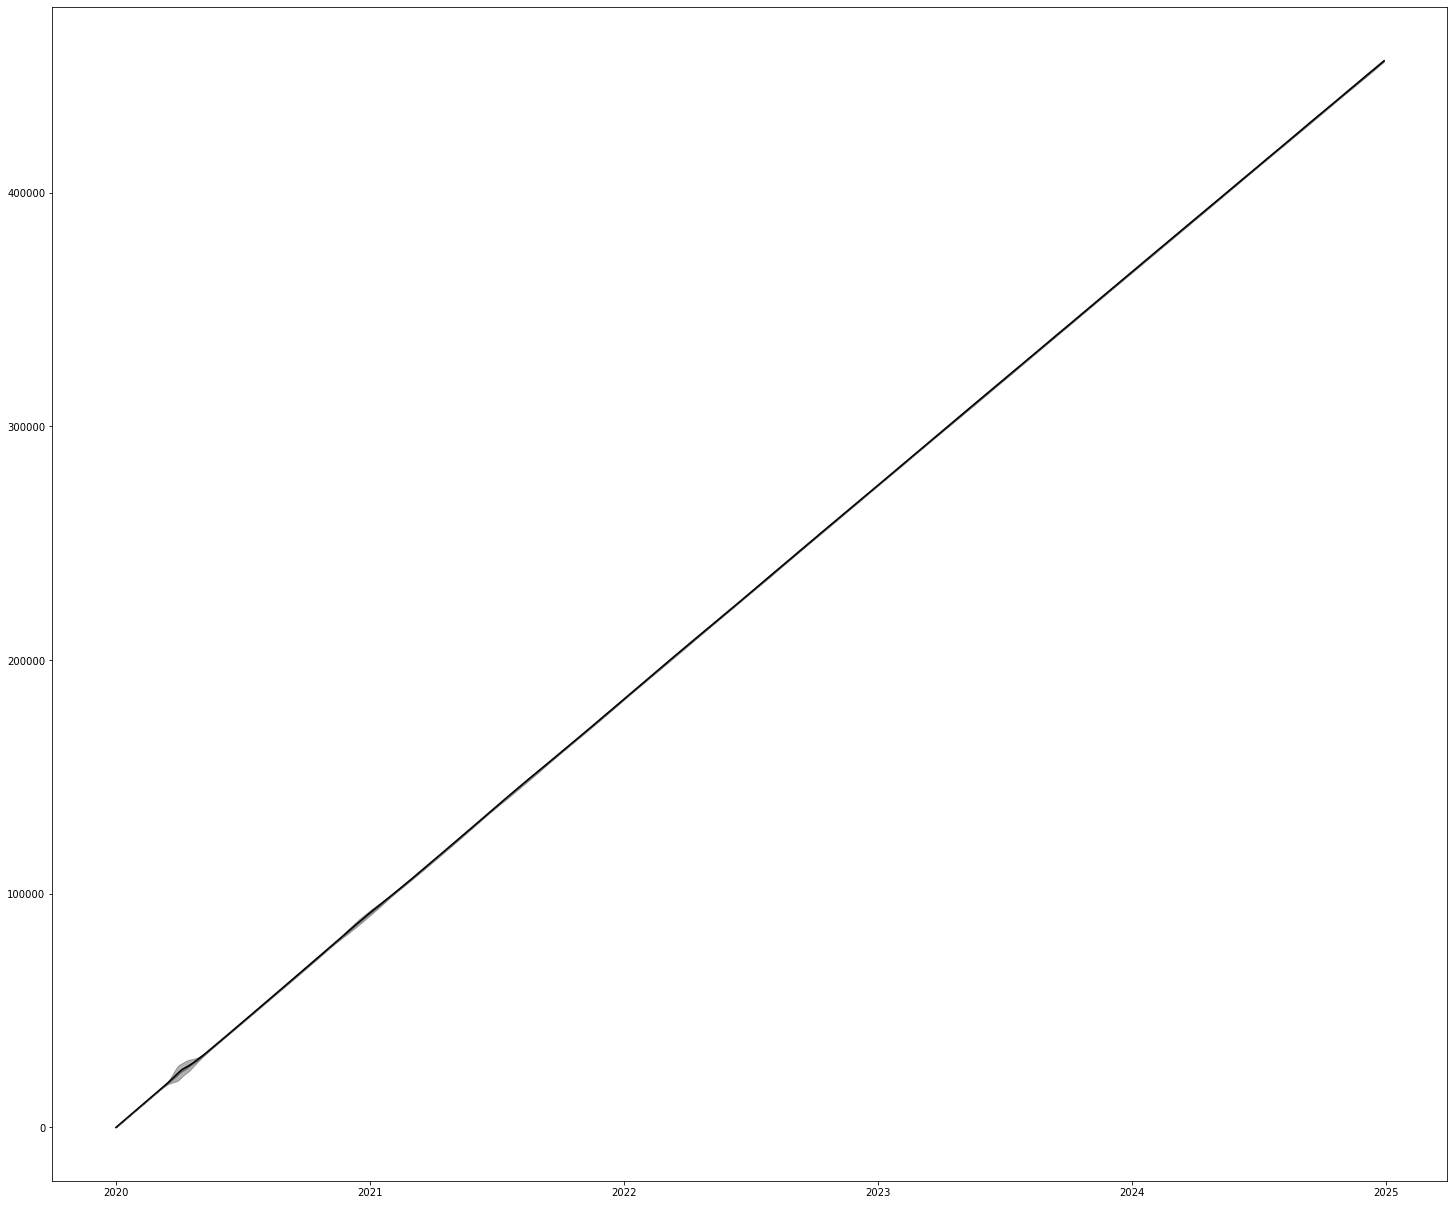

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(25, 21.6))

ax.plot(df_Vac.index.values, df_Vac["median"], color='k', label='Median')
ax.fill_between(df_Vac.index.values, df_Vac["high_95"], df_Vac["low_95"], color='k', alpha=0.3, label='95% CI')
ax.fill_between(df_Vac.index.values, df_Vac["high_50"], df_Vac["low_50"], color='k', alpha=0.3, label='50% CI')

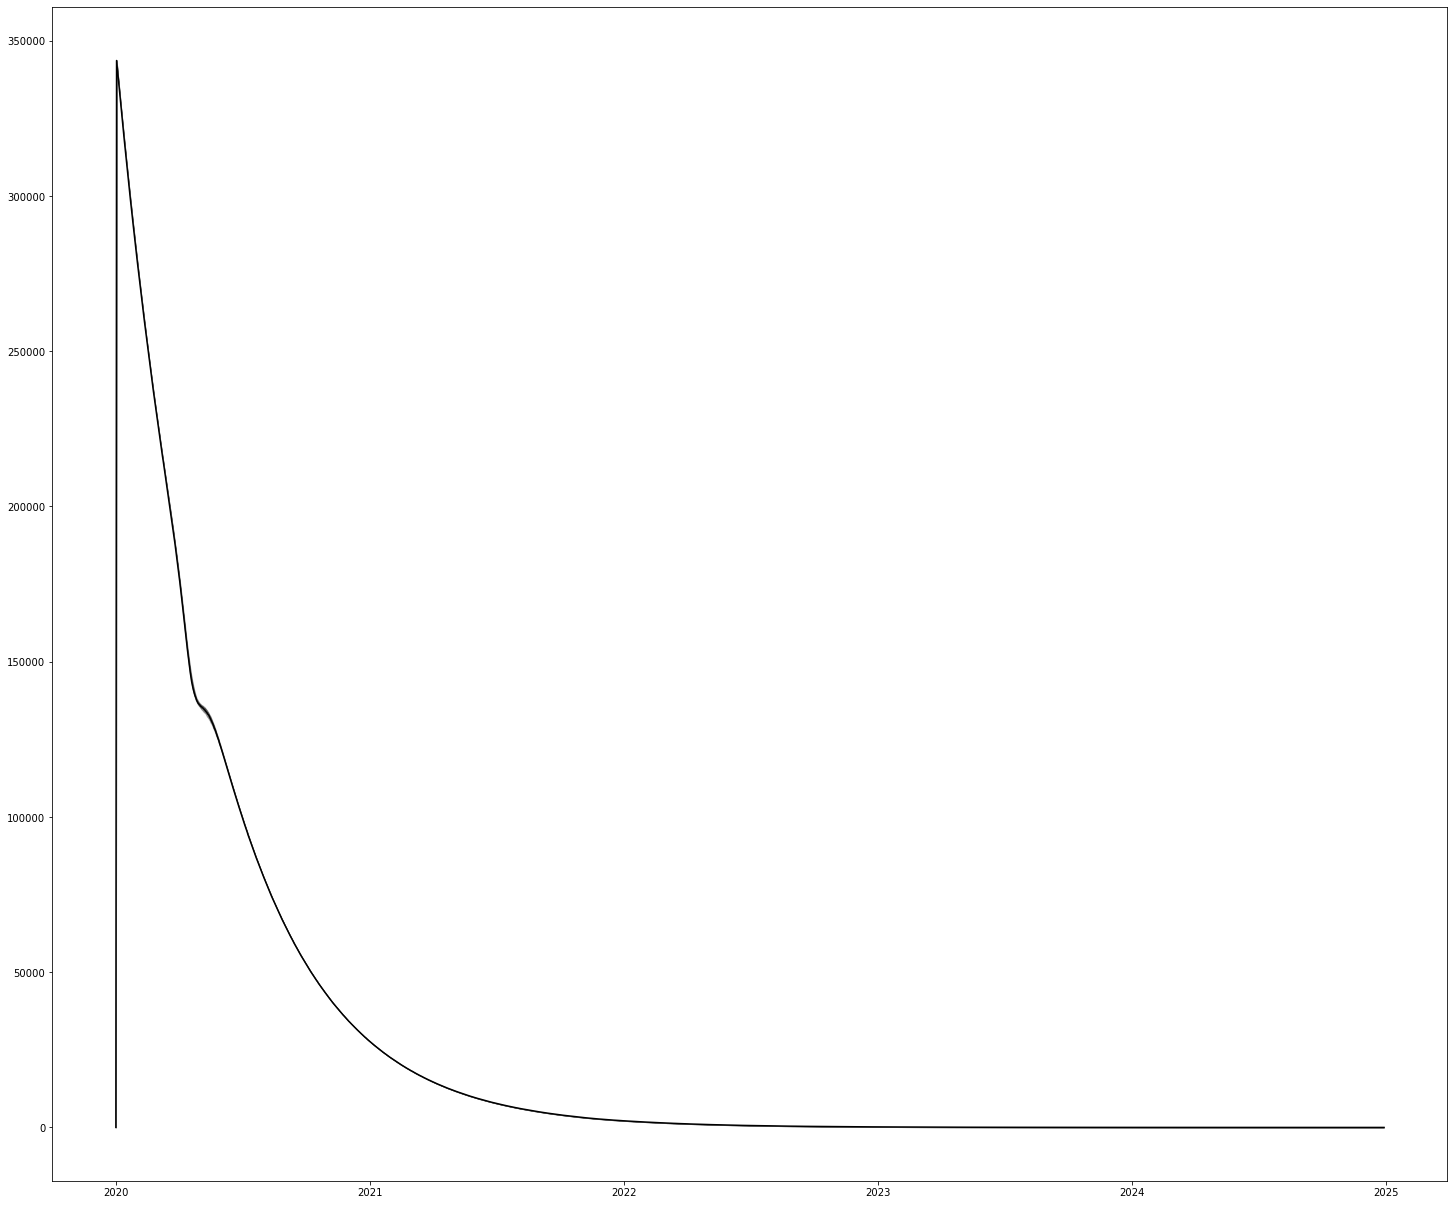

In [13]:
df_V = np.mean(df_all[18,:,:,:], -1)
df_Vac = create_df_response(df_V, time=num_steps, dates =dates)
fig, ax = plt.subplots(1, 1, figsize=(25, 21.6))

ax.plot(df_Vac.index.values, df_Vac["median"], color='k', label='Median')
ax.fill_between(df_Vac.index.values, df_Vac["high_95"], df_Vac["low_95"], color='k', alpha=0.3, label='95% CI')
ax.fill_between(df_Vac.index.values, df_Vac["high_50"], df_Vac["low_50"], color='k', alpha=0.3, label='50% CI')

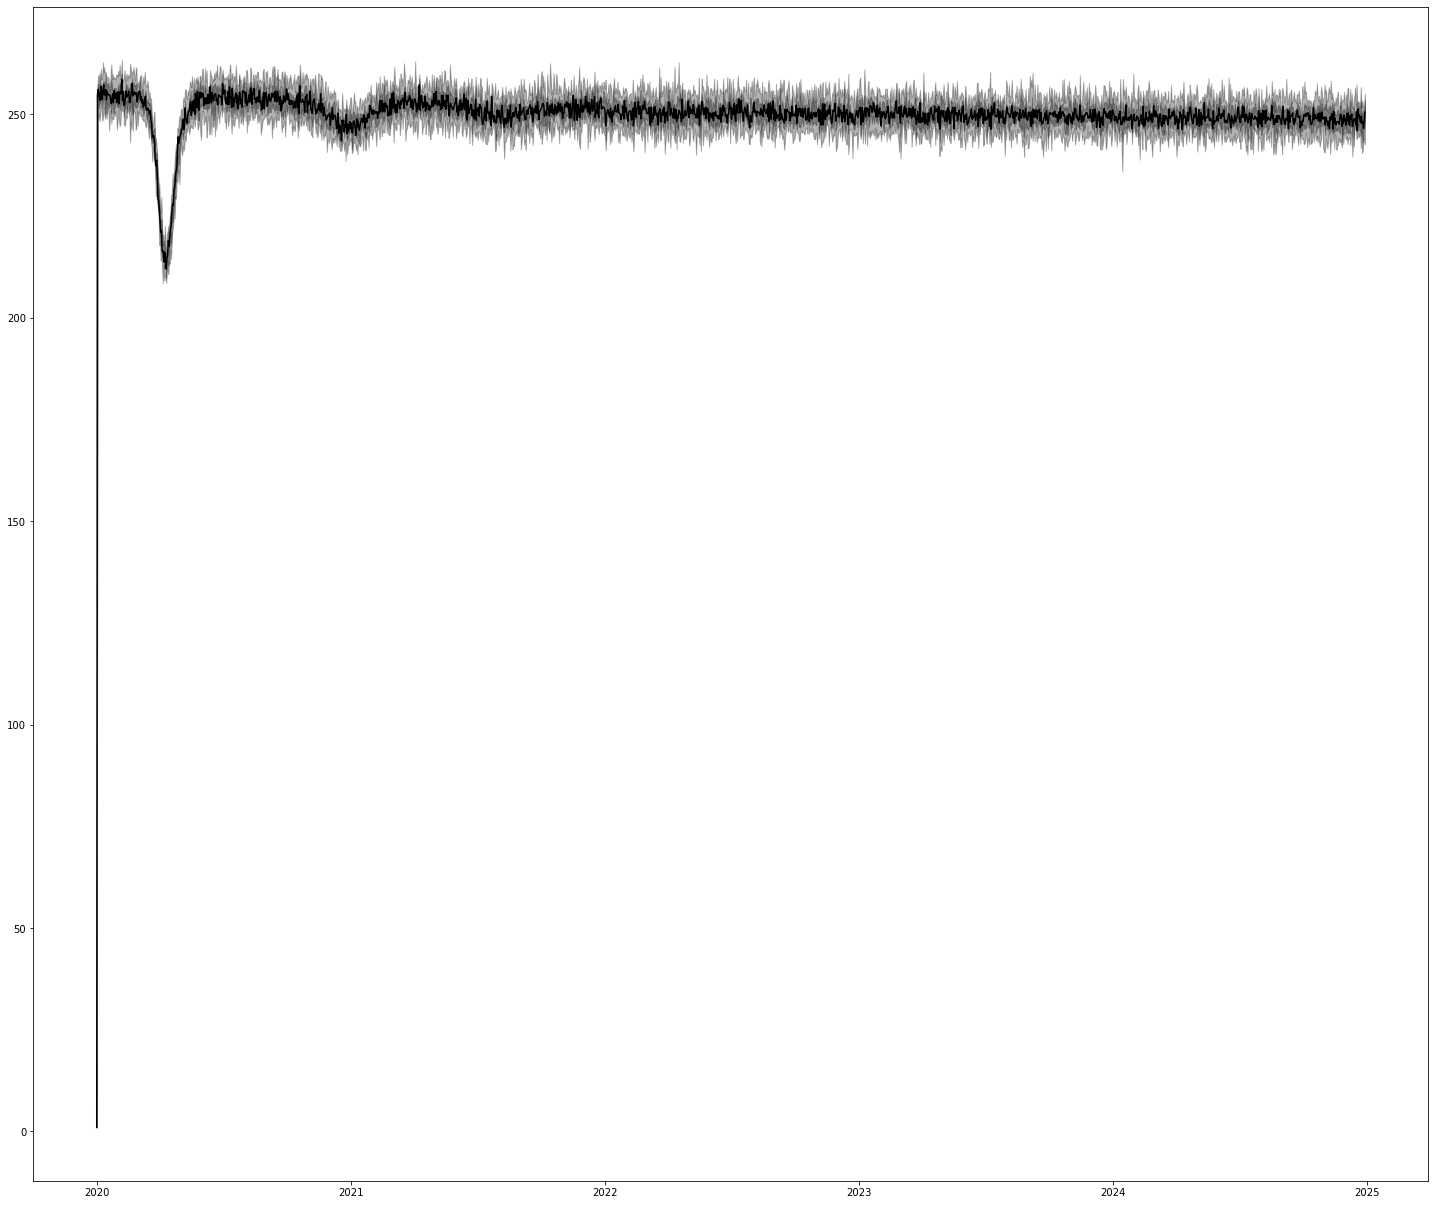

In [9]:
df_V = np.mean(df_all[18,:,:,:], -1)
df_Vac = create_df_response(df_V, time=num_steps, dates =dates)
fig, ax = plt.subplots(1, 1, figsize=(25, 21.6))

ax.plot(df_Vac.index.values, df_Vac["median"], color='k', label='Median')
ax.fill_between(df_Vac.index.values, df_Vac["high_95"], df_Vac["low_95"], color='k', alpha=0.3, label='95% CI')
ax.fill_between(df_Vac.index.values, df_Vac["high_50"], df_Vac["low_50"], color='k', alpha=0.3, label='50% CI')

In [12]:
df_SV

,mean,median,std,low_50,high_50,low_80,high_80,low_95,high_95,type
date,,,,,,,,,,
2020-01-01,4.926377e+07,4.926377e+07,0.000000,4.926377e+07,4.926377e+07,4.926377e+07,4.926377e+07,4.926377e+07,4.926377e+07,estimate
2020-01-02,9.822552e+06,9.822588e+06,601.971480,9.822175e+06,9.822784e+06,9.821775e+06,9.823331e+06,9.821720e+06,9.823507e+06,estimate
2020-01-03,2.515777e+06,2.373431e+06,551892.784984,2.110017e+06,2.772338e+06,1.998220e+06,3.415525e+06,1.956292e+06,3.440790e+06,estimate
2020-01-04,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,estimate
2020-01-05,4.891570e+03,4.887525e+03,13.457943,4.885362e+03,4.896950e+03,4.877820e+03,4.909990e+03,4.873905e+03,4.914985e+03,estimate
...,...,...,...,...,...,...,...,...,...,...
2023-12-26,1.716090e+05,1.715904e+05,122.969189,1.715073e+05,1.717313e+05,1.714564e+05,1.717587e+05,1.714535e+05,1.717646e+05,estimate
2023-12-27,1.715814e+05,1.715960e+05,81.385465,1.715126e+05,1.716457e+05,1.714796e+05,1.716740e+05,1.714605e+05,1.716809e+05,estimate
2023-12-28,1.715959e+05,1.715990e+05,46.176986,1.715720e+05,1.716303e+05,1.715395e+05,1.716520e+05,1.715195e+05,1.716542e+05,estimate


In [13]:
x=init_modelV(pop = population, num_variables=num_var, num_ensembles=num_ensembles)

In [14]:
x.shape

(18, 10)

In [16]:
x[9,0]

1.0

In [17]:
modelV(x=x[:,0], beta=beta, ihr=ihr, hfr = hfr, iVhr= iVhr, hVfr=hVfr, rV= rV, alpha=alpha_s, N=population)

[9822582.0,
 39440939.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0,
 0,
 0,
 251.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0,
 0,
 0]